In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb

warnings.filterwarnings("ignore")

# 데이터 불러오기
file_path = './rainfall_train.csv'
rainfall_train = pd.read_csv(file_path)
# rainfall_train.vv 열이 음수인 경우 해당 행 제거
rainfall_train = rainfall_train[rainfall_train['rainfall_train.vv'] >= 0]
# 연도, 월, 일, 시간 칼럼을 하나의 datetime 칼럼으로 결합 및 변환
year_mapping = {'A': 2001, 'B': 2002, 'C': 2003, 'D': 2004}
rainfall_train['rainfall_train.fc_year'] = rainfall_train['rainfall_train.fc_year'].map(year_mapping)
rainfall_train['rainfall_train.ef_year'] = rainfall_train['rainfall_train.ef_year'].map(year_mapping)

rainfall_train['rainfall_train.fc_datetime'] = pd.to_datetime(rainfall_train[['rainfall_train.fc_year', 'rainfall_train.fc_month', 'rainfall_train.fc_day', 'rainfall_train.fc_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')
rainfall_train['rainfall_train.ef_datetime'] = pd.to_datetime(rainfall_train[['rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')

# 필요 없는 칼럼 제거
rainfall_train.drop(columns=['rainfall_train.fc_year', 'rainfall_train.fc_month', 'rainfall_train.fc_day', 'rainfall_train.fc_hour'], inplace=True)
rainfall_train.drop(columns=['rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour'], inplace=True)

# 구간 확률 계산
rainfall_train['prob_0'] = 100 - rainfall_train['rainfall_train.v01']
rainfall_train['prob_1'] = rainfall_train['rainfall_train.v01'] - rainfall_train['rainfall_train.v02']
rainfall_train['prob_2'] = rainfall_train['rainfall_train.v02'] - rainfall_train['rainfall_train.v03']
rainfall_train['prob_3'] = rainfall_train['rainfall_train.v03'] - rainfall_train['rainfall_train.v04']
rainfall_train['prob_4'] = rainfall_train['rainfall_train.v04'] - rainfall_train['rainfall_train.v05']
rainfall_train['prob_5'] = rainfall_train['rainfall_train.v05'] - rainfall_train['rainfall_train.v06']
rainfall_train['prob_6'] = rainfall_train['rainfall_train.v06'] - rainfall_train['rainfall_train.v07']
rainfall_train['prob_7'] = rainfall_train['rainfall_train.v07'] - rainfall_train['rainfall_train.v08']
rainfall_train['prob_8'] = rainfall_train['rainfall_train.v08'] - rainfall_train['rainfall_train.v09']
rainfall_train['prob_9'] = rainfall_train['rainfall_train.v09']

rainfall_train["expected"] = (rainfall_train["prob_0"] * 0
                + rainfall_train["prob_1"] * 10
                + rainfall_train["prob_2"] * 20
                + rainfall_train["prob_3"] * 30
                + rainfall_train["prob_4"] * 40
                + rainfall_train["prob_5"] * 50
                + rainfall_train["prob_6"] * 60
                + rainfall_train["prob_7"] * 70
                + rainfall_train["prob_8"] * 80
                + rainfall_train["prob_9"] * 90) / 100

rainfall_train.drop(columns=["prob_0","prob_1","prob_2","prob_3","prob_4","prob_5","prob_6","prob_7","prob_8","prob_9"], inplace=True)

# datetime 정보를 유용한 특성으로 변환
rainfall_train['fc_year'] = rainfall_train['rainfall_train.fc_datetime'].dt.year
rainfall_train['fc_month'] = rainfall_train['rainfall_train.fc_datetime'].dt.month
rainfall_train['fc_day'] = rainfall_train['rainfall_train.fc_datetime'].dt.day
rainfall_train['fc_hour'] = rainfall_train['rainfall_train.fc_datetime'].dt.hour

rainfall_train['ef_year'] = rainfall_train['rainfall_train.ef_datetime'].dt.year
rainfall_train['ef_month'] = rainfall_train['rainfall_train.ef_datetime'].dt.month
rainfall_train['ef_day'] = rainfall_train['rainfall_train.ef_datetime'].dt.day
rainfall_train['ef_hour'] = rainfall_train['rainfall_train.ef_datetime'].dt.hour

rainfall_train.drop(columns=['rainfall_train.fc_datetime', 'rainfall_train.ef_datetime'], inplace=True)

# 범주형 변수를 원-핫 인코딩
rainfall_train = pd.get_dummies(rainfall_train, columns=['rainfall_train.stn4contest'], drop_first=True)

# 계절 정보 추가
def get_season(month):
    if month in [5, 6]:
        return '1'
    elif month in [7, 8]:
        return '2'
    else:
        return '3'

rainfall_train['season'] = rainfall_train['fc_month'].apply(get_season)

# 계절별 데이터프레임 생성
df_1 = rainfall_train[rainfall_train['season'] == '1'].reset_index(drop=True)
df_2 = rainfall_train[rainfall_train['season'] == '2'].reset_index(drop=True)
df_3 = rainfall_train[rainfall_train['season'] == '3'].reset_index(drop=True)

# -999 값을 가진 행 제거
rainfall_train = rainfall_train[rainfall_train['rainfall_train.class_interval'] != -999]

# 특성 및 레이블 설정
X = rainfall_train.drop(columns=['Unnamed: 0','rainfall_train.class_interval','rainfall_train.v01','rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04', 'rainfall_train.v05','rainfall_train.v06', 'rainfall_train.v07','rainfall_train.v08', 'rainfall_train.v09','rainfall_train.vv'])
y = rainfall_train['rainfall_train.class_interval']

In [15]:
def train_lstm_model(df):
    # 특성 및 레이블 설정
    X = df.drop(columns=['Unnamed: 0', 'rainfall_train.v01','rainfall_train.v02', 'rainfall_train.v03','rainfall_train.v04','rainfall_train.v05','rainfall_train.v06','rainfall_train.v07', 'rainfall_train.v08', 'rainfall_train.v09', 'rainfall_train.class_interval','rainfall_train.vv', 'season'])
    y = df['rainfall_train.class_interval']

    # 특성 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # y 인덱스 재설정
    y.reset_index(drop=True, inplace=True)

    # LSTM을 위한 시계열 데이터 형태로 변환
    def create_sequences(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps)])
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    time_steps = 10
    X_lstm, y_lstm = create_sequences(X_scaled, y, time_steps)

    # 데이터 분할
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

    # LSTM 모델 정의
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model_lstm.add(LSTM(units=50, return_sequences=False))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(units=1))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    # LSTM 모델 훈련
    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.1)

    # 예측
    y_pred_lstm = model_lstm.predict(X_test_lstm)
    y_pred_lstm = np.round(y_pred_lstm).astype(int).flatten()

    # 결과 저장
    result_df = df.iloc[time_steps:len(y_pred_lstm) + time_steps].copy()
    result_df = result_df.iloc[:len(y_pred_lstm)]
    result_df['estimated_rank'] = y_pred_lstm

    return result_df

# 각 계절별로 모델 학습 및 예측
predictions_1 = train_lstm_model(df_1)
predictions_2 = train_lstm_model(df_2)
predictions_3 = train_lstm_model(df_3)

# 계절별 예측 결과 병합
final_predictions_df = pd.concat([predictions_1, predictions_2, predictions_3])


Epoch 1/10
12828/12828 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - loss: 1.6951 - val_loss: 1.2865
Epoch 2/10
12828/12828 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 1.2505 - val_loss: 1.1182
Epoch 3/10
12828/12828 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 1.0817 - val_loss: 0.9835
Epoch 4/10
12828/12828 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 0.9546 - val_loss: 0.8906
Epoch 5/10
12828/12828 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 0.8698 - val_loss: 0.8406
Epoch 6/10
12828/12828 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 0.7887 - val_loss: 0.7843
Epoch 7/10
12828/12828 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - loss: 0.7433 - val_loss: 0.7396
Epoch 8/10
12828/12828 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 0.6879 - val_loss: 0.6940
Epoch 9/10
12828/12828 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 0.6467 - val_loss: 0.6732
Epoch 10/10
12828/12828 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 0.6090 - val_loss: 0.6440
3564/3564 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Epoch 1/10
13333/13333 ━━━━━━━━━━━━━━━━━━━━ 57

Stacking Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     48055
           1       0.71      0.45      0.55      1020
           2       0.64      0.47      0.54      1510
           3       0.65      0.45      0.53      1391
           4       0.59      0.46      0.52      1400
           5       0.63      0.52      0.57      1831
           6       0.68      0.50      0.58      1383
           7       0.72      0.56      0.63       792
           8       0.85      0.67      0.75       312
           9       0.86      0.83      0.85       256

    accuracy                           0.90     57950
   macro avg       0.73      0.59      0.65     57950
weighted avg       0.89      0.90      0.89     57950

[[47174   128   185   148   148   130    79    36    17    10]
 [  458   463    40    10    16    23     5     1     0     4]
 [  636    28   705    31    44    41    17     7     0     1]
 [  529    13    45   61

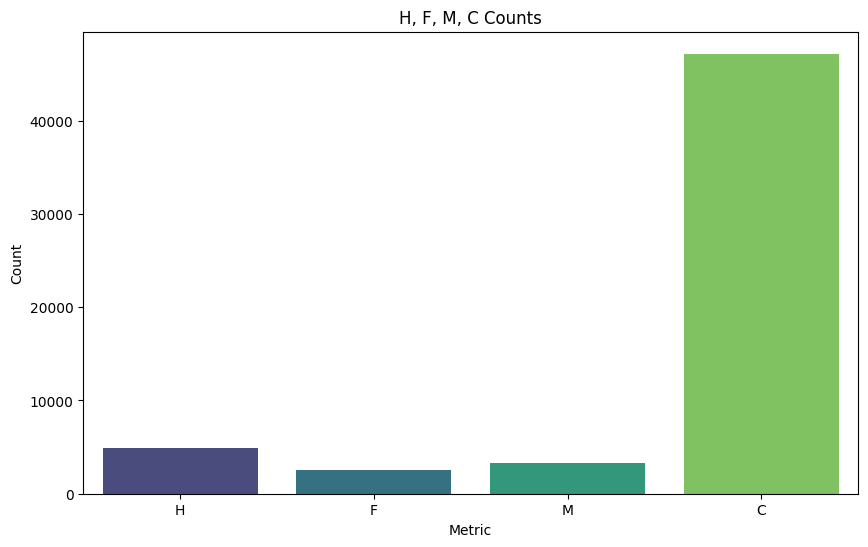

In [16]:
# 스태킹 모델 적용
def train_stacking_model(final_df):
    # 특성 및 레이블 설정
    X = final_df.drop(columns=['Unnamed: 0', 'rainfall_train.v01','rainfall_train.v02', 'rainfall_train.v03','rainfall_train.v04','rainfall_train.v05','rainfall_train.v06','rainfall_train.v07', 'rainfall_train.v08', 'rainfall_train.v09','rainfall_train.vv', 'rainfall_train.class_interval', 'estimated_rank'])
    y = final_df['rainfall_train.class_interval']

    # 특성 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # LSTM 모델 예측 추가
    lstm_predictions = final_df['estimated_rank']

    # XGBoost 모델 훈련 및 예측
    model_xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=10)
    X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model_xgb.fit(X_train_xgb, y_train_xgb)
    xgb_predictions = model_xgb.predict(X_test_xgb)

    # 새로운 훈련 및 테스트 데이터 생성 (원래 특성 + 모델 예측)
    X_train_stack = np.column_stack((X_train_xgb, lstm_predictions[:len(X_train_xgb)]))
    X_test_stack = np.column_stack((X_test_xgb, lstm_predictions[len(X_train_xgb):]))

    # 스태킹 모델 정의
    estimators = [
        ('xgb', model_xgb),
        ('lstm', LogisticRegression())  # LSTM 예측을 Logistic Regression으로 대체
    ]

    stacking_model = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression()
    )

    # 스태킹 모델 훈련
    stacking_model.fit(X_train_stack, y_train_xgb)

    # 예측
    y_pred_stack = stacking_model.predict(X_test_stack)

    # 평가
    print("Stacking Model Performance:")
    print(classification_report(y_test_xgb, y_pred_stack))
    print(confusion_matrix(y_test_xgb, y_pred_stack))

    # 최종 예측 결과를 데이터프레임에 추가
    results_df = pd.DataFrame({'estimated_rank': y_pred_stack, 'rainfall_train.class_interval': y_test_xgb})

    # H, F, M, C 계산 함수
    def calculate_csi_components(df):
        H = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] != 0) & (df['estimated_rank'] == df['rainfall_train.class_interval'])).sum()
        F = ((df['estimated_rank'] != 0) & (df['estimated_rank'] != df['rainfall_train.class_interval'])).sum()
        M = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] != 0)).sum()
        C = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] == 0)).sum()
        return H, F, M, C

    # CSI 계산 함수
    def calculate_csi(H, F, M):
        return H / (H + F + M) if (H + F + M) > 0 else 0

    # H, F, M, C 계산
    H, F, M, C = calculate_csi_components(results_df)

    # CSI 계산
    csi_value = calculate_csi(H, F, M)
    print(f"CSI: {csi_value}")
    print(f"H: {H}, F: {F}, M: {M}, C: {C}")

    # H, F, M, C 값 시각화
    metrics = pd.DataFrame({'Metric': ['H', 'F', 'M', 'C'], 'Count': [H, F, M, C]})

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Count', data=metrics, palette='viridis')
    plt.title('H, F, M, C Counts')
    plt.xlabel('Metric')
    plt.ylabel('Count')
    plt.show()

# 스태킹 모델 학습 및 평가
train_stacking_model(final_predictions_df)